In [1]:
import numpy as np
from numpy import genfromtxt
from itertools import combinations
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
data = genfromtxt('small_file_correct_coord.txt', delimiter=',')
#data = genfromtxt('small_file.txt', delimiter=',')
data[:,4] =(data[:,4]-np.min(data[:,4]))/(np.max(data[:,4])-np.min(data[:,4]))
print(data)

[[ 0.          1.128016    0.913283   -2.69977     0.27121927]
 [ 1.          0.952915    0.519144    0.878809    0.95261156]
 [ 1.          0.434082    0.56767    -2.311936    0.93668561]
 [ 2.          2.209619    1.105468    2.333682    0.52416023]
 [ 3.          1.71197     1.189179    1.119164    0.78435412]
 [ 3.          0.461599    0.777167   -0.144536    0.75403444]
 [ 4.          2.029792    1.287946    1.30295     0.        ]
 [ 5.          0.756178    1.33176    -2.309371    0.68407621]
 [ 6.          2.1872      0.476108    2.85122     0.8842718 ]
 [ 7.          1.921325    1.287711   -2.407052    1.        ]
 [ 7.          0.24677     0.972258    1.512456    0.95922116]
 [ 8.          2.12424     1.190137    0.532672    0.63181968]
 [ 9.          2.165567    0.780356    1.333373    0.52338727]
 [10.          1.927867    0.979187   -1.390222    0.83159162]
 [10.          0.155214    1.058012   -2.217043    0.81032574]
 [11.          2.17151     0.581699   -0.050691    0.75

### reshape data

In [3]:
#print(np.min(data,axis=0)[0])
ll = []
true_vals = []
print(int(np.max(data,axis=0)[0]))
for i in range(int(np.min(data,axis=0)[0]),int(np.max(data,axis=0)[0])+1,3):
    mask = ((data[:,0] == i) | (data[:,0] == i+1) | (data[:,0] == i+2))
    #print("This is mask:")
    #print(mask)
    evt = data[mask]
    #print(evt)
    #print(evt.shape[0])
    pair_indices = list(combinations(range(evt.shape[0]), 2))
    print("pair indices...")
    print(pair_indices)
    for i, (idx1, idx2) in enumerate(pair_indices):
        l = []
        l.append(np.concatenate((evt[idx1,1:],evt[idx2,1:])))
        ll.append(l)
        if (evt[idx1,0] == evt[idx2,0]):
            true_vals.append(1)
        else:
            true_vals.append(0)
#print(ll)
input_data = torch.FloatTensor(ll)
input_data = torch.squeeze(input_data)
input_data.shape
truth_class = torch.FloatTensor(true_vals)
print(input_data.shape)
print(truth_class.shape)

29
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
pair indices...
[(0, 1), (0, 2), (1, 2)]
torch.Size([57, 8])
torch.Size([57])


/home/tobiasjenegger/jupy/jup_notebook/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


### simple model

In [4]:
class feed_forward_model(nn.Module):
        def __init__(self,nodes):
                super().__init__()
                self.linear = torch.nn.Linear(8,nodes)
                #self.another_linear = torch.nn.Linear(100,100)
                self.activation = torch.nn.ReLU()
                self.linear_back = torch.nn.Linear(nodes,1)

        def forward(self, x):
                output_tensor = self.linear(x)
                #output_tensor = self.another_linear(output_tensor)
                #output_tensor = self.activation(output_tensor)
                output_tensor = self.linear_back(output_tensor)
                output_tensor = torch.sigmoid(output_tensor)
                output_tensor = torch.squeeze(output_tensor)
                return output_tensor


## final training

In [5]:
print(input_data.shape)
n_epochs = 1000
model = feed_forward_model(100)
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.SGD(model.parameters(), lr=9e-4)
model.train()
loss_val = []
for epoch in range(n_epochs):
    y_pred = model(input_data)
    y_true = truth_class
    loss = loss_fn(y_pred,y_true)
    loss_val.append(loss.detach().item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')
    torch.save(model,"ff_scripted.pt")

torch.Size([57, 8])
Finished epoch 0, latest loss 0.6756450533866882
Finished epoch 1, latest loss 0.6720675826072693
Finished epoch 2, latest loss 0.6685458421707153
Finished epoch 3, latest loss 0.6650784015655518
Finished epoch 4, latest loss 0.6616647839546204
Finished epoch 5, latest loss 0.6583037972450256
Finished epoch 6, latest loss 0.6549946069717407
Finished epoch 7, latest loss 0.6517360806465149
Finished epoch 8, latest loss 0.6485275626182556
Finished epoch 9, latest loss 0.6453681588172913
Finished epoch 10, latest loss 0.6422567963600159
Finished epoch 11, latest loss 0.6391928195953369
Finished epoch 12, latest loss 0.6361752152442932
Finished epoch 13, latest loss 0.6332033276557922
Finished epoch 14, latest loss 0.6302762627601624
Finished epoch 15, latest loss 0.6273932456970215
Finished epoch 16, latest loss 0.6245535612106323
Finished epoch 17, latest loss 0.6217563152313232
Finished epoch 18, latest loss 0.6190009117126465
Finished epoch 19, latest loss 0.6162864

Finished epoch 244, latest loss 0.4150010943412781
Finished epoch 245, latest loss 0.4147481322288513
Finished epoch 246, latest loss 0.41449689865112305
Finished epoch 247, latest loss 0.4142473340034485
Finished epoch 248, latest loss 0.4139993190765381
Finished epoch 249, latest loss 0.413752943277359
Finished epoch 250, latest loss 0.41350823640823364
Finished epoch 251, latest loss 0.41326504945755005
Finished epoch 252, latest loss 0.413023442029953
Finished epoch 253, latest loss 0.4127833843231201
Finished epoch 254, latest loss 0.412544846534729
Finished epoch 255, latest loss 0.4123077690601349
Finished epoch 256, latest loss 0.4120722711086273
Finished epoch 257, latest loss 0.41183823347091675
Finished epoch 258, latest loss 0.4116056263446808
Finished epoch 259, latest loss 0.4113744795322418
Finished epoch 260, latest loss 0.41114479303359985
Finished epoch 261, latest loss 0.4109165072441101
Finished epoch 262, latest loss 0.41068965196609497
Finished epoch 263, latest l

Finished epoch 435, latest loss 0.38431596755981445
Finished epoch 436, latest loss 0.38420817255973816
Finished epoch 437, latest loss 0.38410067558288574
Finished epoch 438, latest loss 0.3839934766292572
Finished epoch 439, latest loss 0.3838866055011749
Finished epoch 440, latest loss 0.38377997279167175
Finished epoch 441, latest loss 0.38367363810539246
Finished epoch 442, latest loss 0.38356760144233704
Finished epoch 443, latest loss 0.3834618926048279
Finished epoch 444, latest loss 0.3833564519882202
Finished epoch 445, latest loss 0.3832513689994812
Finished epoch 446, latest loss 0.3831464946269989
Finished epoch 447, latest loss 0.3830419182777405
Finished epoch 448, latest loss 0.38293758034706116
Finished epoch 449, latest loss 0.3828335702419281
Finished epoch 450, latest loss 0.3827298581600189
Finished epoch 451, latest loss 0.38262641429901123
Finished epoch 452, latest loss 0.38252320885658264
Finished epoch 453, latest loss 0.38242030143737793
Finished epoch 454, l

Finished epoch 625, latest loss 0.36763063073158264
Finished epoch 626, latest loss 0.36755698919296265
Finished epoch 627, latest loss 0.3674834370613098
Finished epoch 628, latest loss 0.36741000413894653
Finished epoch 629, latest loss 0.367336630821228
Finished epoch 630, latest loss 0.36726340651512146
Finished epoch 631, latest loss 0.36719024181365967
Finished epoch 632, latest loss 0.3671172261238098
Finished epoch 633, latest loss 0.36704427003860474
Finished epoch 634, latest loss 0.3669714331626892
Finished epoch 635, latest loss 0.36689871549606323
Finished epoch 636, latest loss 0.3668260872364044
Finished epoch 637, latest loss 0.36675354838371277
Finished epoch 638, latest loss 0.36668112874031067
Finished epoch 639, latest loss 0.36660879850387573
Finished epoch 640, latest loss 0.36653655767440796
Finished epoch 641, latest loss 0.36646443605422974
Finished epoch 642, latest loss 0.3663924038410187
Finished epoch 643, latest loss 0.36632049083709717
Finished epoch 644,

Finished epoch 831, latest loss 0.35420361161231995
Finished epoch 832, latest loss 0.35414525866508484
Finished epoch 833, latest loss 0.3540869653224945
Finished epoch 834, latest loss 0.3540286719799042
Finished epoch 835, latest loss 0.3539704382419586
Finished epoch 836, latest loss 0.3539123237133026
Finished epoch 837, latest loss 0.353854238986969
Finished epoch 838, latest loss 0.353796124458313
Finished epoch 839, latest loss 0.3537381589412689
Finished epoch 840, latest loss 0.35368025302886963
Finished epoch 841, latest loss 0.3536223769187927
Finished epoch 842, latest loss 0.35356447100639343
Finished epoch 843, latest loss 0.3535066843032837
Finished epoch 844, latest loss 0.3534489572048187
Finished epoch 845, latest loss 0.3533913195133209
Finished epoch 846, latest loss 0.35333365201950073
Finished epoch 847, latest loss 0.3532760739326477
Finished epoch 848, latest loss 0.35321855545043945
Finished epoch 849, latest loss 0.3531610667705536
Finished epoch 850, latest 

Text(0, 0.5, 'loss value')

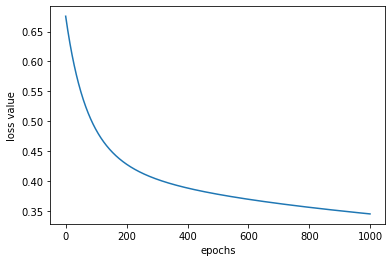

In [6]:
plt.plot(loss_val)
plt.xlabel("epochs")
plt.ylabel("loss value")

### look at pred. value distributions

In [7]:
#ff_model = feed_forward_model()
with torch.no_grad():
    model = torch.load("ff_scripted.pt")
    model.eval()
    
eval_pred = model(input_data).detach().numpy()   
eval_true = truth_class.detach().numpy()




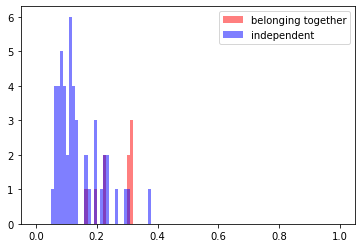

In [8]:
plt.hist(eval_pred[eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
plt.hist(eval_pred[eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
plt.legend()

In [9]:
      
def run_lr(min_val,max_val,stepsize):
    #assert min_val.isdigit(), f"number is not integer, got: {type(min_val)}"
    #assert max_val.isdigit(), f"number is not integer, got: {type(max_val)}"
    #assert stepsize.isdigit(), f"number is not integer, got: {type(stepsize)}"
    n_epochs = 1000
    model = feed_forward_model(100)
    loss_fn = nn.BCELoss()  # binary cross entropy
    loss_step_vals =[]
    for i in range(stepsize):
            lr_i = ((max_val - min_val)/stepsize)*i+min_val 
            optimizer = optim.SGD(model.parameters(), lr=lr_i)
            model.train()
            loss_val = []
            for epoch in range(n_epochs):
                y_pred = model(input_data)
                y_true = truth_class
                loss = loss_fn(y_pred,y_true)
                loss_val.append(loss.detach().item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            loss_step_vals.append(loss_val)
    return loss_step_vals
    
    
    
    

#def run_out_features(min_val,max_val,stepsize):
    

In [10]:
min_val = 1e-3
max_val = 9e-2
stepsize = 10

test = run_lr(min_val,max_val,stepsize)

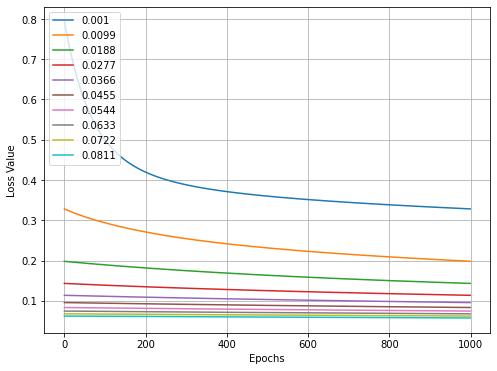

In [14]:


lable_targets = [((max_val - min_val)/stepsize)*i+min_val for i in range(stepsize)]
formatted_labels = [f'{label:.4g}' for label in lable_targets]

plt.figure(figsize=(8, 6))

for y,label in zip(test,formatted_labels):
    plt.plot(y,label=label)
    

plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend(loc='upper left')  # Add a legend to identify the lines
plt.grid(True)